#  Prediction using Synthetic Feedback Knowledge

In this final notebook, we explored whether a model trained on customer feedback can transfer its knowledge to improve a fallback model  – even for customers who left no feedback.



### Project Structure:

1. **Exploring Customer Churn & GPT-generated Feedback**  
   → Data exploration & text insights

2. **Feedback Noise Simulation & Fallback Testing**  
   → Simulate real-world feedback imperfections

3. **Fallback Model – Logistic vs XGB vs RF vs NN**  
   → Structured-only models, compared & evaluated

4. **Model with Feedback – Logistic vs XGB vs NN**  
   → Hybrid modeling using structured + textual data

5. **Prediction using Synthetic Feedback Knowledge**  
   → Transfer feedback model knowledge to fallback model


## 📑 Table of Contents

[1. Imports](#1-imports)<br>
[2. Load data](#2-load-data)<br>
[3. Generate synthetic_text_score](#3-generate-synthetic_text_score)<br>
[4. Prepare fallback dataset with the synthetic score](#4-prepare-fallback-dataset-with-the-synthetic-score)<br>
[5. Model comparison – baseline vs enhanced](#5-model-comparison--baseline-vs-enhanced)<br>
[6. Define & Train](#6-define--train)<br>
[7. Evaluate](#7-evaluate)<br>
[8. Summary](#8-summary)<br>
[📁Notebook Series Overview: Telco Churn & GPT Feedback](#notebook-series-overview-telco-churn--gpt-feedback)


## 1. Imports
<a id="1-imports"></a> 


In [1]:

import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression


## 2. Load data
<a id="2-load-data"></a>

In [2]:
# Load full dataset (with and without feedback)
df = pd.read_csv("/kaggle/input/telco-customer-churn-realistic-customer-feedback/telco_noisy_feedback_prep.csv")  # adjust if needed

# Load the trained model with feedback
model_with_feedback = joblib.load("/kaggle/input/telco-customer-churn-realistic-customer-feedback/model_with_feedback.pkl")

In [3]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'customerID', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'CustomerFeedback', 'feedback_length', 'sentiment',
       'HasFeedback'],
      dtype='object')

## 3. Generate synthetic_text_score
<a id="3-generate-synthetic_text_score"></a>  

In [4]:
# Copy and fill missing feedback with empty string 
df["CustomerFeedback"] = df["CustomerFeedback"].fillna("")

# Apply model to all rows
synthetic_scores = model_with_feedback.predict_proba(df)[:, 1]

# Add to dataframe
df["synthetic_text_score"] = synthetic_scores

# print preview
df[["CustomerFeedback", "synthetic_text_score"]].head()

,CustomerFeedback,synthetic_text_score
0,,0.542417
1,,0.347213
2,,0.452751
3,,0.402545
4,,0.786120


## 4. Prepare fallback dataset with the synthetic variable
<a id="4-prepare-fallback-dataset-with-the-synthetic-score"></a>  

In [5]:
# Select fallback subset
df_fallback = df[~df["HasFeedback"]].copy()

# Target
target_col = "Churn"
y_fallback = df_fallback[target_col]

# Features: original + synthetic score
numeric_base = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical = ["Contract", "PaymentMethod", "InternetService", "Partner", "Dependents"]
enhanced_features = numeric_base + ["synthetic_text_score"] + categorical

X_fallback = df_fallback[enhanced_features]

## 5. Model comparison – baseline vs enhanced
<a id="4-prepare-fallback-dataset-with-the-synthetic-score"></a>  

In [6]:
# Features
num_base = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = ["Contract", "PaymentMethod", "InternetService", "Partner", "Dependents"]
target_col = "Churn"

# Enhanced = base + synthetic score
num_enhanced = num_base + ['synthetic_text_score']

In [7]:
# Only customers without feedback
df_fallback = df[~df["HasFeedback"]].copy()

# Baseline
X_base = df_fallback[num_base + cat_cols]
y_base = df_fallback[target_col]

# Enhanced
X_enhanced = df_fallback[num_enhanced + cat_cols]
y_enhanced = df_fallback[target_col]

# Same split for both
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=y_base
)

X_enh_train, X_enh_test, y_enh_train, y_enh_test = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

## 6. Difine & Train
<a id="6-define--train"></a>  

In [8]:
# Shared categorical transformer
cat_transformer = OneHotEncoder(handle_unknown="ignore")

# Baseline pipeline
pipe_base = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("num", StandardScaler(), num_base),
        ("cat", cat_transformer, cat_cols)
    ])),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Enhanced pipeline
pipe_enhanced = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("num", StandardScaler(), num_enhanced),
        ("cat", cat_transformer, cat_cols)
    ])),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Train both
pipe_base.fit(X_base_train, y_base_train)
pipe_enhanced.fit(X_enh_train, y_enh_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'synthetic_text_score']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Contract', 'PaymentMethod',
                                                   'InternetService', 'Partner',
                                                   'Dependents'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

## 7. Evaluate 
<a id="7-evaluate"></a> 

In [9]:
# Predictions and probabilities
y_base_pred = pipe_base.predict(X_base_test)
y_base_prob = pipe_base.predict_proba(X_base_test)[:, 1]

y_enh_pred = pipe_enhanced.predict(X_enh_test)
y_enh_prob = pipe_enhanced.predict_proba(X_enh_test)[:, 1]

# Scores
print("🔹 Baseline fallback model:")
print(classification_report(y_base_test, y_base_pred))
print("ROC AUC:", roc_auc_score(y_base_test, y_base_prob))

print("\n🔸 Enhanced fallback model (with synthetic score):")
print(classification_report(y_enh_test, y_enh_pred))
print("ROC AUC:", roc_auc_score(y_enh_test, y_enh_prob))

🔹 Baseline fallback model:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       775
           1       0.67      0.59      0.63       280

    accuracy                           0.81      1055
   macro avg       0.76      0.74      0.75      1055
weighted avg       0.81      0.81      0.81      1055

ROC AUC: 0.8460069124423963

🔸 Enhanced fallback model (with synthetic score):
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       775
           1       0.66      0.59      0.62       280

    accuracy                           0.81      1055
   macro avg       0.76      0.74      0.75      1055
weighted avg       0.81      0.81      0.81      1055

ROC AUC: 0.8457073732718894


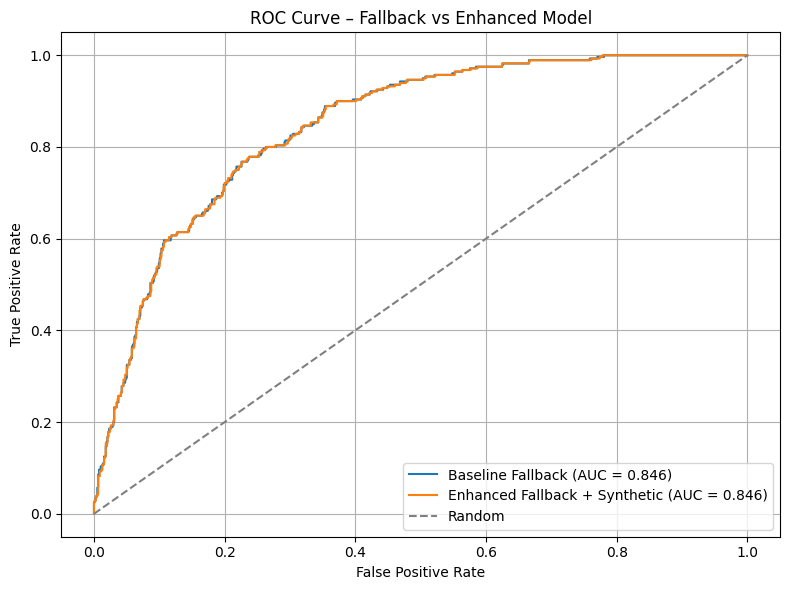

In [10]:
# Calculate ROC curves
fpr_base, tpr_base, _ = roc_curve(y_base_test, y_base_prob)
fpr_enh, tpr_enh, _ = roc_curve(y_enh_test, y_enh_prob)

auc_base = auc(fpr_base, tpr_base)
auc_enh = auc(fpr_enh, tpr_enh)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f"Baseline Fallback (AUC = {auc_base:.3f})", color="#1f77b4")
plt.plot(fpr_enh, tpr_enh, label=f"Enhanced Fallback + Synthetic (AUC = {auc_enh:.3f})", color="#ff7f0e")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Fallback vs Enhanced Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Summary
<a id="8-summary"></a>  

We loaded a feedback-based Logistic Regression model (`model_with_feedback.pkl`), applied it to all customers to generate a new feature: `synthetic_text_score`, added this variable to the fallback dataset, compared two models: 1. A baseline fallback model (structured data only), 2. An enhanced fallback model (structured + synthetic score)

### Result:
Despite expectations, both models performed nearly identically:
- Baseline AUC: **0.846**
- Enhanced AUC: **0.846**

This suggests that in this specific setup, the additional synthetic signal did not provide extra lift — likely due to data being relatively easy to predict or the signal being redundant.



Still, the architecture built here demonstrates a **reusable hybrid approach**, where insights from rich data (text) can inform simpler fallback systems.

## 📁 Notebook Series Overview: **Telco Churn & GPT Feedback**
<a id="notebook-series-overview-telco-churn--gpt-feedback"></a>

This is part of a multi-notebook series focused on **realistic churn prediction** using structured data and GPT-generated customer feedback.  
We simulate real-world challenges such as missing text, noisy input, and model fallback logic — building toward a robust, production-style solution.

---

###  1. Exploring Customer Churn & GPT-generated Feedback

> Exploratory analysis of the churn dataset, with focus on customer segments, behavior patterns, and text feedback characteristics.  
> Text insights powered by GPT-generated responses.

---

###  2. Feedback Noise Simulation & Fallback Testing

> We simulate feedback imperfections (irrelevant, incomplete, or missing entries) and measure how models perform under noise.  
> Introduces the concept of fallback systems for low-signal situations.

---

### 3. Fallback Model – Logistic vs XGB vs RF vs NN

> We train and compare multiple classifiers on **structured-only data** (no feedback):  
> Logistic Regression, Random Forest, XGBoost, and Neural Net.  
> Best fallback model is selected based on ROC AUC and recall.

---

###  4. Model with Feedback – Logistic vs XGB vs NN

> We focus on customers who left written feedback.  
> Structured data is combined with TF-IDF vectors to train a stronger “teacher” model.  
> Logistic Regression emerges as the most interpretable and best-performing solution.

---

### 5. Prediction using Synthetic Feedback Knowledge

> Even when customers don’t leave feedback, we simulate its predictive signal using the trained teacher model.  
> We generate a `synthetic_text_score` and evaluate whether it helps fallback performance.

---
